<a href="https://colab.research.google.com/github/Rehan-Mullani/Architecting-LLMs-WiDS/blob/main/week3/makemore_part2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[ 0.8752,  0.9987, -0.9505,  ..., -0.9615,  0.3766, -0.8830],
        [-0.9625,  0.9998, -0.9823,  ..., -0.9457,  0.7251, -0.9696],
        [ 0.9667,  0.9998, -0.9417,  ..., -0.1534,  0.3973, -0.8027],
        ...,
        [-0.7745,  1.0000, -0.9995,  ..., -0.9999,  0.9970, -0.9999],
        [ 0.9998,  1.0000, -0.9945,  ..., -0.9832,  0.9834, -0.9991],
        [ 0.9966,  0.2619, -0.8729,  ..., -0.9880, -0.9178, -0.9044]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(15.8494)

In [21]:
# ------------ now made respectable :) ---------------

In [22]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [36]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 15), generator=g)
W1 = torch.randn((45, 250), generator=g)
b1 = torch.randn(250, generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [37]:
sum(p.nelement() for p in parameters) # number of parameters in total

18682

In [38]:
for p in parameters:
  p.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [39]:
lri = []
lossi = []
stepi = []

In [46]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 15)
  h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (32, 250)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

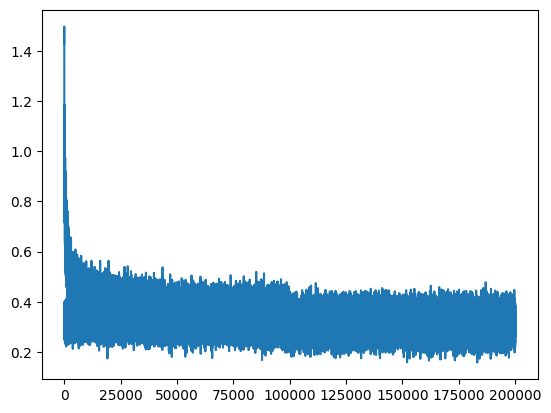

In [47]:
plt.plot(stepi, lossi)

In [48]:
emb = C[Xtr] # (100, 3, 15)
h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (100, 250)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0213, grad_fn=<NllLossBackward0>)

In [49]:
emb = C[Xdev] # (100, 3, 15)
h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (100, 250)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1288, grad_fn=<NllLossBackward0>)

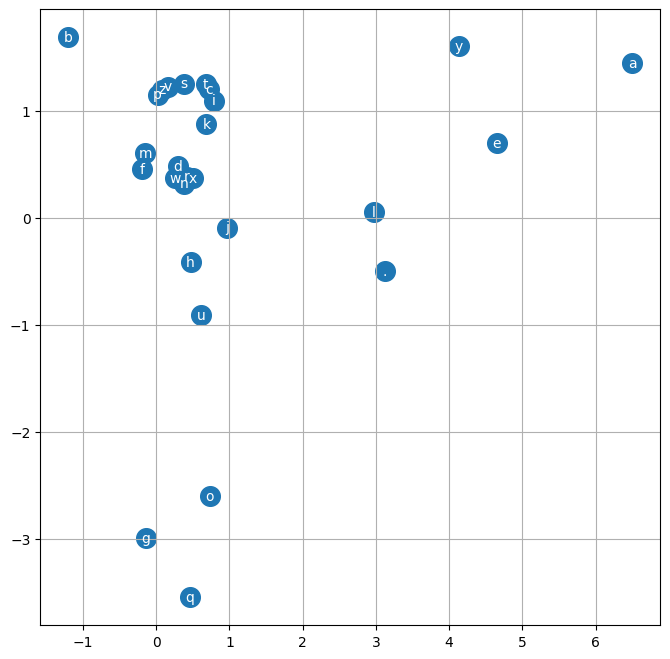

In [51]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [33]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [34]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [50]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrir.
xhealynn.
cassie.
mahuel.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
jord.
quinton.
lilah.
jadilyn.
jero.
dearyxi.
jaxeeniguan.
edde.
